In [20]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

def SIR(y, t, beta, gamma):
    """
    :param y: initial condition
    :param t: time
    :param beta: para
    :param gamma: para
    :return: the SIR model ODEs
    """
    S, I, R = y
    dS = - beta * S * I
    dI = beta * S * I - gamma * I
    dR = gamma * I
    return [dS, dI, dR]

In [21]:
# initial condition
S0 = 9999
I0 = 1
R0 = 0
y = S0, I0, R0

# true parameters
beta = 0.00003
gamma = 0.05

# time
t = np.linspace(0, 100, 50)

# simulate SIR
solution = scipy.integrate.odeint(SIR, [S0, I0, R0], t, args=(beta, gamma))
S, I, R = solution.T

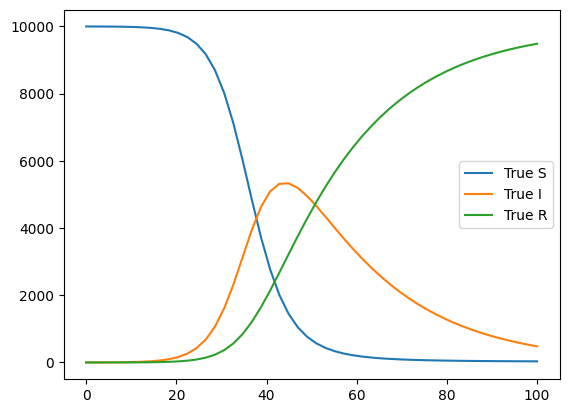

In [22]:
# plot the real S I R and our generated data I_clean and I_noisy
# assume we only observe the state I

plt.plot(t, S, label="True S")
plt.plot(t, I, label="True I")
plt.plot(t, R, label="True R")
plt.legend()
plt.show()

\begin{equation}
I(t) = I(0) + (\beta(S(0)+I(0))-\gamma)
\int_0^t I(\tau)\, d\tau - \beta \int_0^t I(\tau)^2\, d\tau - \beta \gamma \int_0^t I(\tau)
\left(
\int_0^{\tau} I(s)\, ds
\right) d\tau
\end{equation}

Estimated beta: -2.7365641475315317e-08 --- real beta 3e-05
Estimated gamma: -41.0651765156684 --- real gamma 0.05
Estimated S0 1496763746.4464605 -- real S0 9999
Estimated alpha: -40.9599000585036
239
nfev: 300
njev: 240
status: 0
message: The maximum number of function evaluations is exceeded.


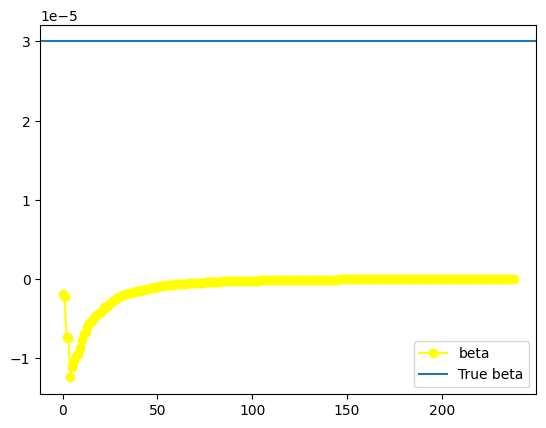

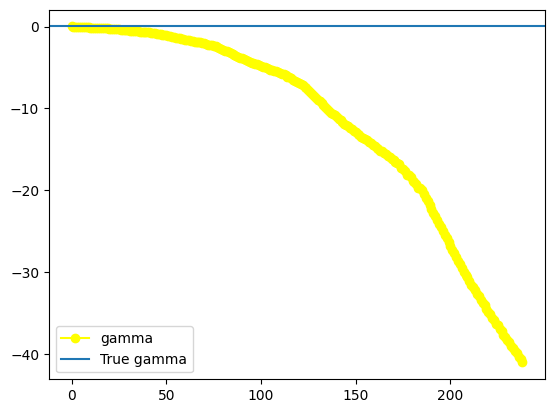

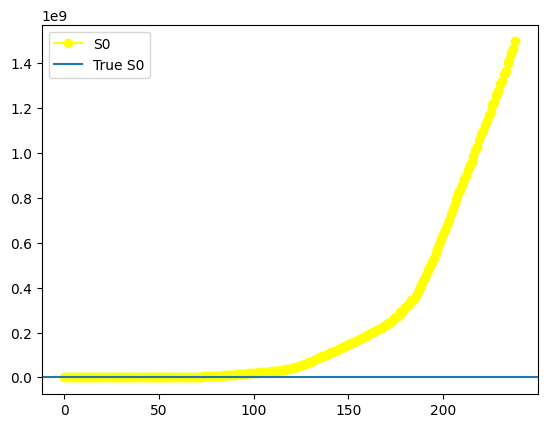

In [23]:
# estimate the integral using the data points
from scipy.integrate import simpson
from scipy.optimize import least_squares
I_data = I + np.random.normal(0, 0.01 * I, size=I.shape) # we could change this to I clean freely

I_int = np.array([simpson(I_data[:i+1], t[:i+1]) for i in range(len(t))])
I_int2 = np.array([simpson(I_data[:i+1]**2, t[:i+1]) for i in range(len(t))])

"""
Directly compute double integral
"""
# int_double = np.zeros_like(I_data)
# for i in range(len(t)):
#     inner = np.array([simpson(I_data[:j+1], t[:j+1]) for j in range(i+1)])
#     int_double[i] = simpson(I_data[:i+1] * inner, t[:i+1])

"""
Integration by parts
"""
int_double = 1/2 * (I_int ** 2)

def residual_(paras, I_data, I_int, I_int2, int_double, I0):
    beta, gamma, alpha = paras
    I_hat = I0 + ((alpha + beta * I0) - gamma) * I_int - beta * I_int2 - beta * gamma * int_double
    return I_data - I_hat

def residual(paras, I_data):
    I0 = I_data[0]
    I_int = np.array([simpson(I_data[:i+1], t[:i+1]) for i in range(len(t))])
    I_int2 = np.array([simpson(I_data[:i+1]**2, t[:i+1]) for i in range(len(t))])
    int_double = 1/2 * (I_int ** 2)
    beta, gamma, alpha = paras
    I_hat = I0 + ((alpha + beta * I0) - gamma) * I_int - beta * I_int2 - beta * gamma * int_double
    return I_data - I_hat

# initial guess value of beta and gamma
beta0 = 0.00000000000000000000000000000000000000000001
gamma0 = 0.01
S00 = 100
alpha_initial = beta0 * S00
x0 = [beta0, gamma0, alpha_initial]

# store the intermediate value for beta and gamma
beta_list = []
gamma_list = []
S0_list = []
def callback(x):
    beta_list.append(x[0])
    gamma_list.append(x[1])
    S0_list.append(x[2] / x[0])

# least squares
res = least_squares(residual, x0, args=(I_data,), callback=callback)
print(f"Estimated beta: {res.x[0]} --- real beta {beta}"
      f"\nEstimated gamma: {res.x[1]} --- real gamma {gamma}"
      f"\nEstimated S0 {res.x[2] / res.x[0]} -- real S0 {S0}"
      f"\nEstimated alpha: {res.x[2]}")

# plot
assert len(beta_list) == len(gamma_list) == len(S0_list)
print(len(beta_list))
print("nfev:", res.nfev)
print("njev:", res.njev)
print("status:", res.status)
print("message:", res.message)

plt.plot(beta_list, label="beta", marker='o', color='yellow')
plt.axhline(y=beta, label="True beta", linestyle='-')
plt.legend()
plt.show()

plt.plot(gamma_list, label="gamma", marker='o', color='yellow')
plt.axhline(y=gamma, label="True gamma", linestyle='-')
plt.legend()
plt.show()

plt.plot(S0_list, label="S0", marker='o', color='yellow')
plt.axhline(y=S0, label="True S0", linestyle='-')
plt.legend()
plt.show()

## Noise level

Assume noise is normally distributed. We study the noise variance from 1% to 20% of max(I)

In [ ]:
noise_steps = 41
noise_levels = [0.005 * i for i in range(noise_steps)]  # 0% to 20%
x_noise_percent = [0.5 * i for i in range(noise_steps)]

def residual(paras, I_data, I_int, I_int2, int_double, I0):
        beta, gamma, alpha = paras
        I_hat = I0 + ((alpha + beta * I0) - gamma) * I_int - beta * I_int2 - beta * gamma * int_double
        return I_data - I_hat

# initial guess value of beta and gamma
beta0 = 0.009
gamma0 = 0.05
S0_initial = 1000
alpha_initial = beta0 * S0_initial
x0 = [beta0, gamma0, alpha_initial]

num_of_iterations = 20

results = {
    "beta": {"mean": [], "std": []},
    "gamma": {"mean": [], "std": []},
    "S0":   {"mean": [], "std": []}
}

for noise_level in noise_levels:
    beta_list = []
    gamma_list = []
    S0_list = []
    for _ in range(num_of_iterations):
        I_data = I + np.random.normal(0, noise_level * I, size=I.shape)
        I_data = np.maximum(I_data, 0)
        I_int = np.array([simpson(I_data[:i+1], t[:i+1]) for i in range(len(t))])
        I_int2 = np.array([simpson(I_data[:i+1]**2, t[:i+1]) for i in range(len(t))])
        int_double = 1/2 * (I_int ** 2)

        # least squares
        res = least_squares(residual, x0, args=(I_data, I_int, I_int2, int_double, I_data[0]), callback=callback)
        beta_list.append(res.x[0])
        gamma_list.append(res.x[1])
        S0_list.append(res.x[2] / res.x[0])

    results["beta"]["mean"].append(np.mean(beta_list))
    results["beta"]["std"].append(np.std(beta_list))

    results["gamma"]["mean"].append(np.mean(gamma_list))
    results["gamma"]["std"].append(np.std(gamma_list))

    results["S0"]["mean"].append(np.mean(S0_list))
    results["S0"]["std"].append(np.std(S0_list))

# plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
params = ["beta", "gamma", "S0"]
true_values = [beta, gamma, S0]

for i, param in enumerate(params):
    ax = axes[i]
    means = np.array(results[param]["mean"])
    stds = np.array(results[param]["std"])

    # Plot Mean
    ax.plot(x_noise_percent, means, label=f"Estimated {param}", color="blue", marker="o", markersize=3)

    # Plot True Value
    ax.axhline(y=true_values[i], label=f"True {param}", color="orange", linestyle="--", linewidth=2)

    # Plot Standard Deviation
    ax.fill_between(x_noise_percent, means - stds, means + stds, color="blue", alpha=0.2, label="Std Dev")

    ax.set_title(f"Robustness of {param}")
    ax.set_xlabel("Noise Level (% of max I)")
    ax.set_ylabel("Parameter Value")
    fig.patch.set_facecolor("white")
    ax.set_facecolor("white")
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.show()

## Number of datapoints

Now we fix the noise level to be 5% of max(I) and the range of period to be up to 500. We change the step size to analyse the performance given different number of data points

In [ ]:
num_of_data_list = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000]

results = {
    "beta": {"mean": [], "std": []},
    "gamma": {"mean": [], "std": []},
    "S0":   {"mean": [], "std": []}
}

# initial guess value of beta and gamma
beta0 = 0.01
gamma0 = 0.05
S0_initial = 100
alpha_initial = beta0 * S0_initial
x0 = [beta0, gamma0, alpha_initial]

def residual(paras, I_data, I_int, I_int2, int_double):
    beta, gamma, alpha = paras
    I_hat = I0 + ((alpha + beta * I_data[0]) - gamma) * I_int - beta * I_int2 - beta * gamma * int_double
    return I_data - I_hat

for steps in num_of_data_list:
    beta_result = []
    gamma_result = []
    S0_result = []

    # time
    t = np.linspace(0, 500, steps)

    # simulate SIR
    solution = scipy.integrate.odeint(SIR, [S0, I0, R0], t, args=(beta, gamma))
    S, I, R = solution.T

    for _ in range(20):
        # I data
        I_data = I + np.random.normal(0, 0.05 * I, size=I.shape)
        I_data = np.maximum(I_data, 0)

        I_int = np.array([simpson(I_data[:i+1], t[:i+1]) for i in range(len(t))])
        I_int2 = np.array([simpson(I_data[:i+1]**2, t[:i+1]) for i in range(len(t))])
        int_double = 1/2 * (I_int ** 2)

        # lease squares
        res = least_squares(residual, x0, args=(I_data, I_int, I_int2, int_double))
        beta_result.append(res.x[0])
        gamma_result.append(res.x[1])
        S0_result.append(res.x[2] / res.x[0])

    results["beta"]["mean"].append(np.mean(beta_result))
    results["beta"]["std"].append(np.std(beta_result))
    results["gamma"]["mean"].append(np.mean(gamma_result))
    results["gamma"]["std"].append(np.std(gamma_result))
    results["S0"]["mean"].append(np.mean(S0_result))
    results["S0"]["std"].append(np.std(S0_result))

# plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
param_names = ["beta", "gamma", "S0"]
true_params = [beta, gamma, S0]

for i, param in enumerate(param_names):
    ax = axes[i]
    means = np.array(results[param]["mean"])
    stds = np.array(results[param]["std"])

    # Plot Mean and True Value
    ax.plot(num_of_data_list, means, label=f"Estimated {param}", color="green", marker="o")
    ax.axhline(y=true_params[i], label=f"True {param}", color="orange", linestyle="--")

    # Plot Error Band
    ax.fill_between(num_of_data_list, means - stds, means + stds, color="green", alpha=0.2, label="Std Dev")

    ax.set_title(f"Sensitivity to Sampling Density: $\\{param}$")
    ax.set_xlabel("Number of Data Points ($N$)")
    ax.set_ylabel("Estimated Value")
    fig.patch.set_facecolor("white")
    ax.set_facecolor("white")
    ax.set_xticks(num_of_data_list[::2])
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.show()